# GRECO Angular Error Random Forest Regressor
Our goal is to create a random forest regressor that has predictive power for the angular uncertainty of events in the GRECO sample. We use the Pegleg track direction as our reco direction, and include variables from the Pegleg track fit (energy, zenith, azimuth) as well as parameters of the fit (logl, rlogl) and do the same for the Monopod fit. We try to fit to the opening angle between the true primary neutrino direction and the Pegleg track reco direction

In [16]:
import numpy as np
from glob import glob as glob
import pickle
import h5py
import inspect
import astropy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import pandas as pd
%matplotlib inline
%load_ext memory_profiler
from matplotlib import cm

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [2]:
FileNames = ['../GRECO_nugen_numu_LE_with_PeglegCasc.h5', '../GRECO_nugen_numu_ME_with_PeglegCasc.h5', '../GRECO_genie_numu_with_PeglegCascade.h5']
NFiles = [4879, 644, 735]

In [3]:
#Some helpful functions to read in from h5 files and mask arrays

def getTruth(neutrinoKey, weightKey):
    trueDict = {}
    for key in ['energy', 'zenith', 'azimuth', 'type', 
                'OneWeight', 'NEvents', 'MaxEnergyLog', 
                'MinEnergyLog', 'OneWeightbyNGen']:
        trueDict[key] = np.array([])
        
    for i in range(3):
        f = h5py.File(FileNames[i], 'r')
        for item in ['energy', 'zenith', 'azimuth', 'type']:
            trueDict[item] = np.append(trueDict[item], f[neutrinoKey][item])
        for item in ['OneWeight', 'NEvents', 'MaxEnergyLog', 'MinEnergyLog']:
            trueDict[item] = np.append(trueDict[item], f[weightKey][item])
        trueDict['OneWeightbyNGen'] = np.append(trueDict['OneWeightbyNGen'], 
                                                f[weightKey]['OneWeight'] / (f[weightKey]['NEvents'] * NFiles[i]) )
    return trueDict

def getRecos(recoName, recoFits):
    recoDict = {}
    for key in ['energy', 'zenith', 'azimuth',
               'logl', 'rlogl']:
        recoDict[key] = np.array([])
        
    recoVars = ['energy', 'zenith', 'azimuth']
    recoParams = ['logl', 'rlogl']
    
    for i in range(3):
        f = h5py.File(FileNames[i], 'r')
        for item in recoVars:
            recoDict[item] = np.append(recoDict[item], f[recoName][item])
        for item in recoParams:
            recoDict[item] = np.append(recoDict[item], f[recoFits][item])
            
    angularSeparation(recoDict, true)
    return recoDict

def angularSeparation(reco, truth):
    reco['angErr'] = np.arccos(np.sin(reco['zenith'])*np.sin(truth['zenith']) +
                        (np.cos(reco['zenith']) *np.cos(truth['zenith']) * np.cos(reco['azimuth'] - truth['azimuth'])) ) 

def maskAllRecos():
    mask = np.zeros_like(Pegleg_track['energy'])
    for reco in [Pegleg_track, Pegleg_cascade, Monopod, true]:
        mask += np.isnan(reco['energy'])
        mask += np.isnan(reco['zenith'])
        mask += np.isinf(reco['zenith'])
        mask += np.isinf(reco['energy']) #get rid of this if energy = 0 is helpful
    print np.unique(mask)
    print mask
    mask = map(bool, mask)
    mask = [not x for x in mask]
    for reco in [Pegleg_track, Pegleg_cascade, Monopod, true]:
        for key in reco.keys():
            reco[key] = reco[key][mask]

In [4]:
true = getTruth('MCNeutrino', 'I3MCWeightDict')
Pegleg_track = getRecos('Pegleg_Fit_MN_tol10Track', 'Pegleg_Fit_MN_tol10FitParams')
Pegleg_cascade = getRecos('Pegleg_Fit_MN_tol10HDCasc', 'Monopod_bestFitParams')
Monopod = getRecos('Monopod_best', 'Monopod_bestFitParams')
maskAllRecos()

[0.]
[0. 0. 0. ... 0. 0. 0.]


## Now, combine all the relevant variables into one pandas DataFrame object
Also, create a deltaLLH key

In [30]:
allRecoDict = {}
for key in Monopod.keys():
    if "Monopod" in key:
        continue
    if "Pegleg" in key:
        continue
    if "delta" in key:
        continue
    newKey = r'Monopod' + key
    allRecoDict[newKey] = Monopod[key]
for key in Pegleg_track.keys():
    newKey = r'Pegleg' + key
    allRecoDict[newKey] = Pegleg_track[key]
allRecoDict['trueEnergy'] = true['energy']
allRecoDict['weight'] = true['OneWeightbyNGen']
allRecoDict['RecoOpeningAngle'] = np.arccos(np.sin(Monopod['zenith'])*np.sin(Pegleg_track['zenith']) +
                        (np.cos(Monopod['zenith']) *np.cos(Pegleg_track['zenith']) * np.cos(Monopod['azimuth'] - Pegleg_track['azimuth'])))
allRecoDict[r'deltaLLH'] = Monopod['logl'] - Pegleg_track['logl']
df = pd.DataFrame.from_dict(allRecoDict)

In [31]:
df.head()

,MonopodangErr,Monopodazimuth,Monopodenergy,Monopodlogl,Monopodrlogl,Monopodzenith,PeglegangErr,Peglegazimuth,Peglegenergy,Pegleglogl,Peglegrlogl,Peglegzenith,RecoOpeningAngle,deltaLLH,trueEnergy,weight
0,0.613894,4.055607,92.689673,443.207290,0.086446,1.596748,0.126199,5.391408,41.07,427.896208,0.083459,2.311967,0.735479,15.311082,104.427464,0.022004
1,0.282742,1.679301,106.457096,871.944397,0.166561,1.875081,0.013883,1.622129,101.01,756.523997,0.144513,2.169186,0.295054,115.420400,743.641074,27.305518
2,1.425892,0.278354,65.180687,323.992705,0.063491,0.797929,0.102329,0.593499,44.40,313.565366,0.061447,2.345468,1.523472,10.427339,111.274111,0.053448
3,0.585630,3.602136,126.278412,258.078865,0.050803,1.364980,0.319225,4.675444,37.74,243.065624,0.047848,1.788324,0.363163,15.013241,184.626066,0.279530
4,0.294499,5.834126,44.648198,311.484296,0.061147,1.512880,0.191116,6.187156,15.54,310.576754,0.060969,1.060167,0.456685,0.907542,262.447356,0.744312


## Let's transform some of these variables
Not all of these variables are in the most helpful forms. We suspect some might function better given the transformations below: 

* Energy $\rightarrow \; \log$ Energy 
* Zenith $\rightarrow \; \cos$ Zenith
* Angular Error $\rightarrow \; \log$ Angular Error

In [7]:
%memit
thing = True
print '{}hello'.format(thing)

peak memory: 724.31 MiB, increment: 0.27 MiB
Truehello


In [32]:
for key in df.keys():
    if "energy" in key:
        df[key] = np.log10(df[key])
    if "zenith" in key:
        df[key] = np.cos(df[key])
    if "angErr" in key and True:
        df[key] = np.log10(df[key])
    if "OpeningAngle" in key and True:
        df[key] = np.log10(df[key])
        
df = df.replace([np.inf, -np.inf], np.nan) #Some of these result in log(0) -> -inf, so remask
df = df.dropna(axis=0) 

/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
np.count_nonzero(np.isinf(df['Pegleg_angErr']))

0

In [11]:
np.power([2], 20)

array([1048576])

## Standardize Data

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

feature_cols = list(df.keys())
feature_cols.remove('MonopodangErr')
feature_cols.remove('PeglegangErr')
feature_cols.remove('Monopodazimuth')
feature_cols.remove('Peglegazimuth')
feature_cols.remove('trueEnergy')
feature_cols.remove('weight')

X,y = df[feature_cols].values, df['PeglegangErr'].values

X_train, X_test, y_train, y_test =  train_test_split(X, y, 
                                                     test_size=0.5, 
                                                     random_state=1) 

stdsc = StandardScaler()
X_train_std = stdsc.fit(X_train).transform(X_train)
X_test_std = stdsc.transform(X_test)

df_train_std = pd.DataFrame(X_train_std,columns=feature_cols)
df_train_std_targets = pd.DataFrame(y_train, columns = ["PeglegangErr"])


In [38]:
sns.set(style='whitegrid', context='notebook')
#cols = df.columns[:]

df_train_with_targets = pd.concat([df_train_std, df_train_std_targets], axis = 1, sort = False)

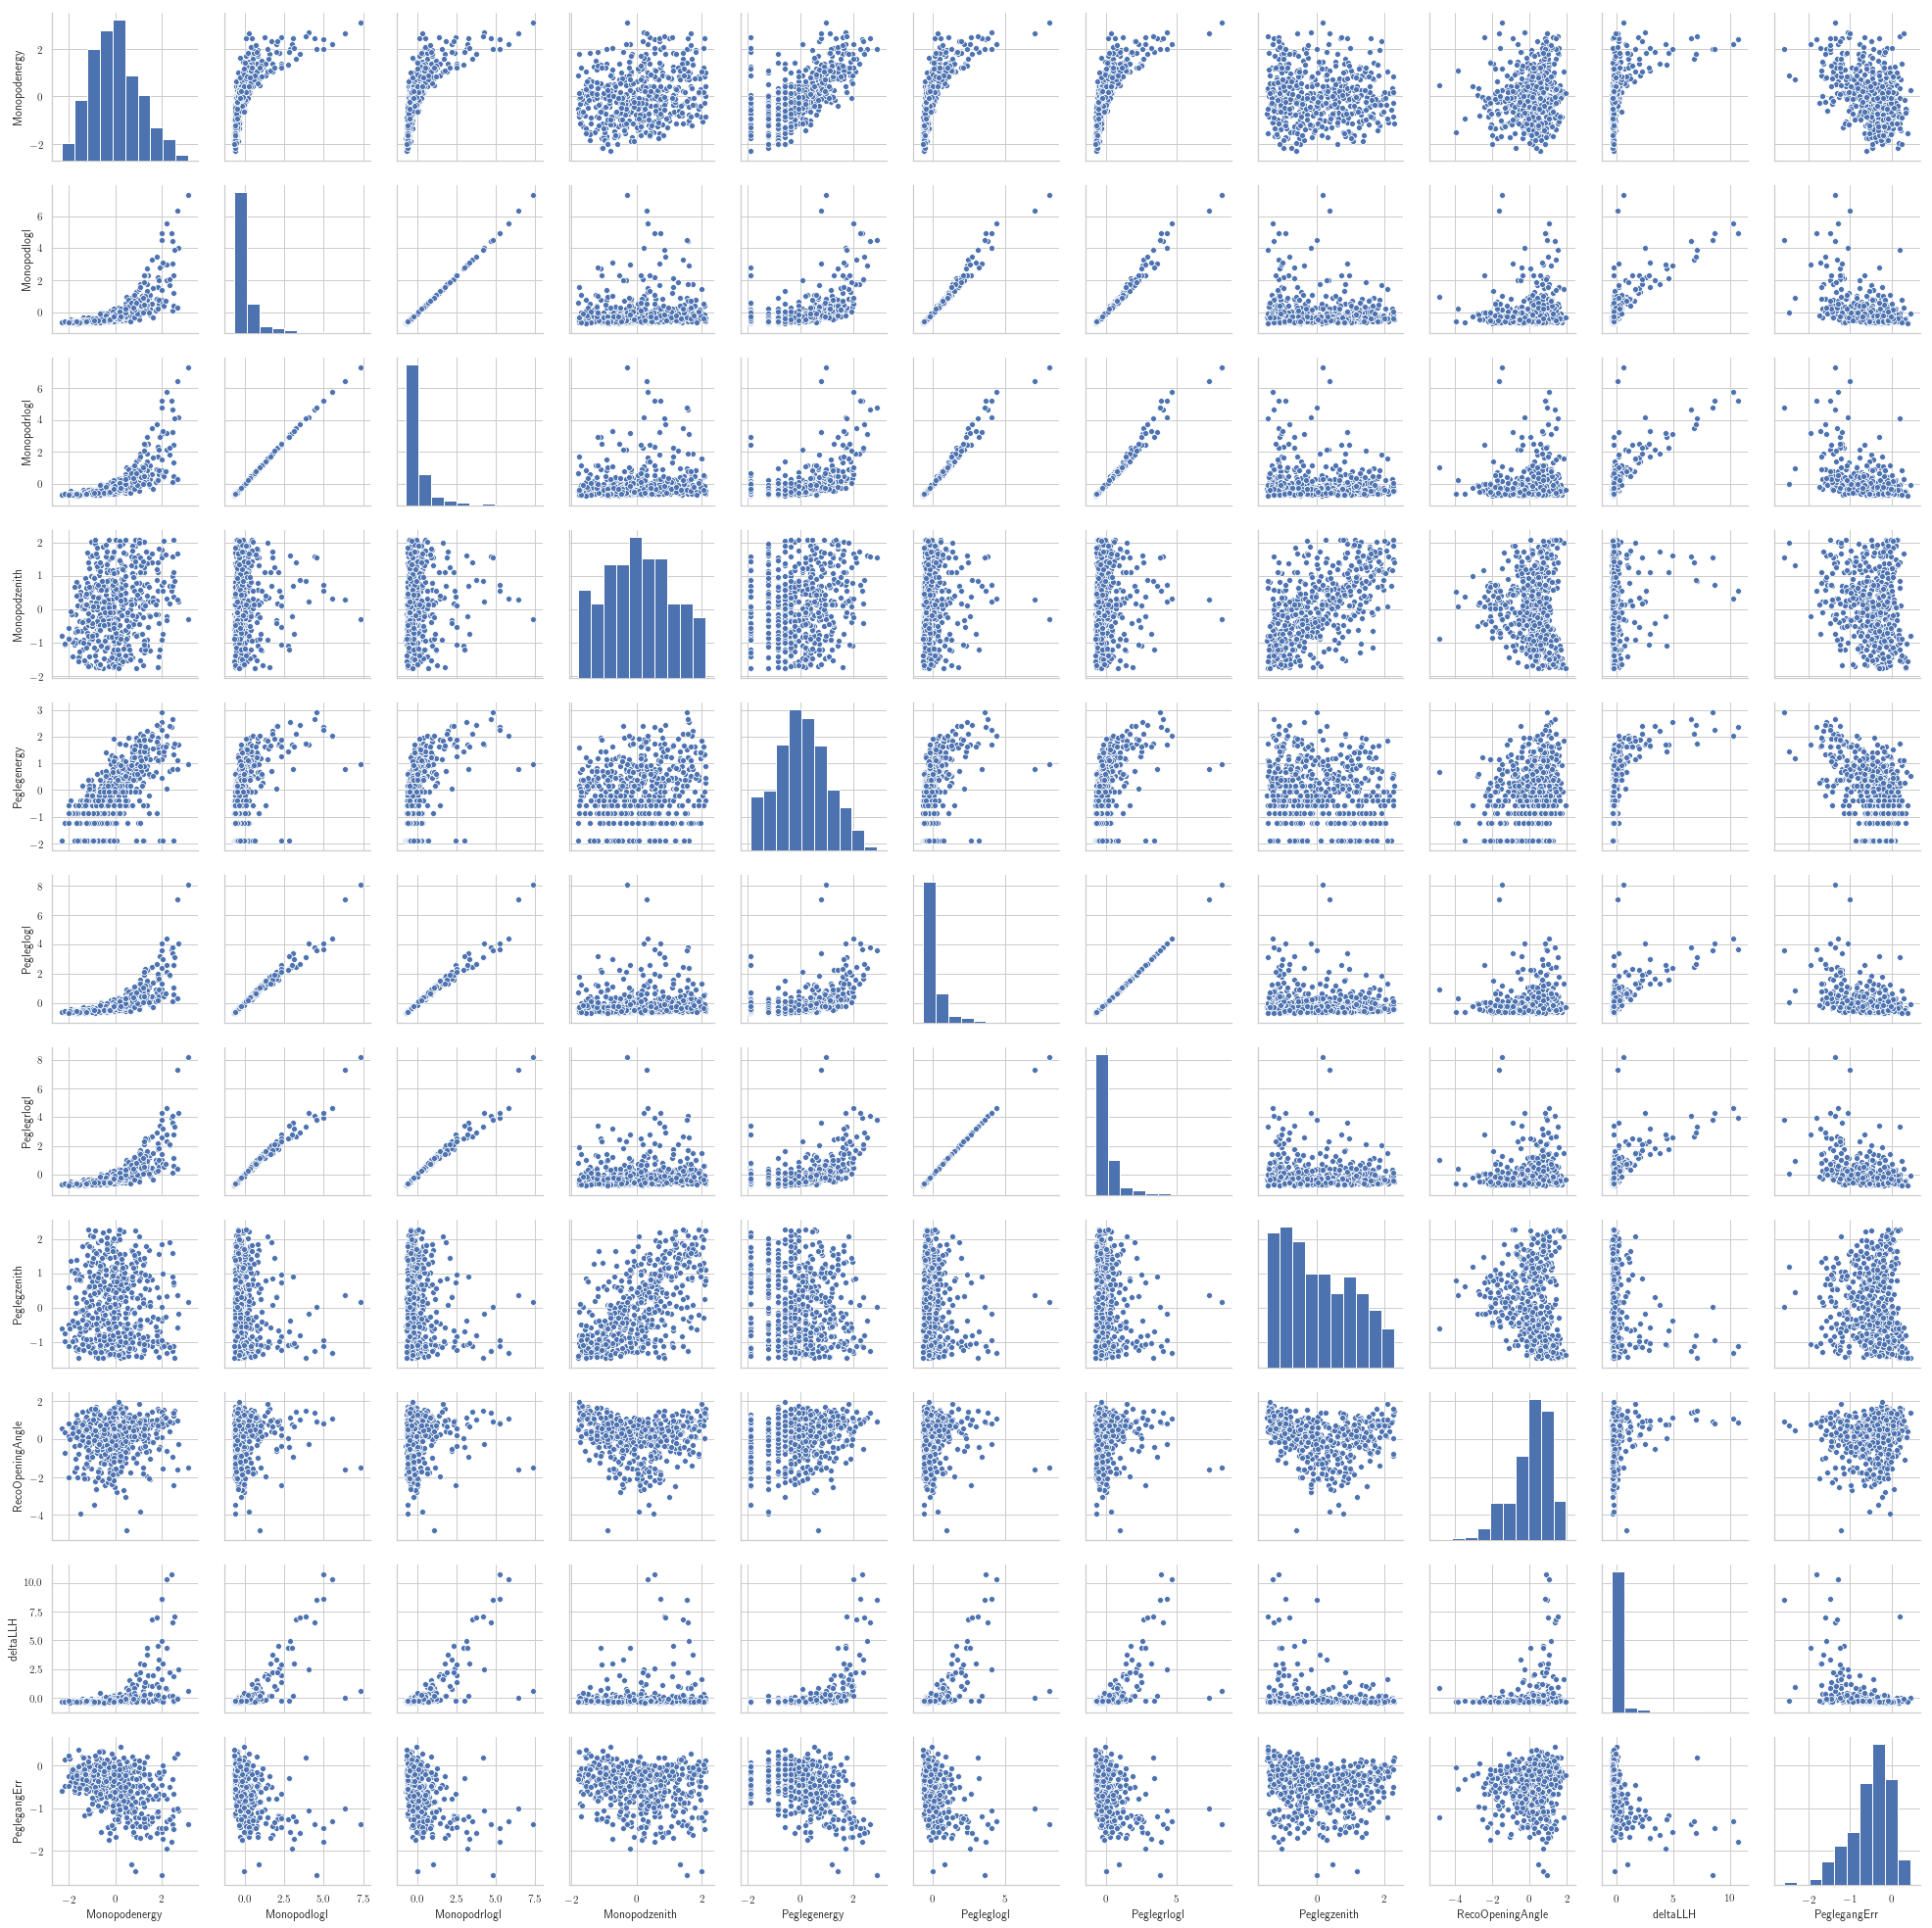

In [39]:
sns.pairplot(df_train_with_targets.sample(n=500));
plt.show()

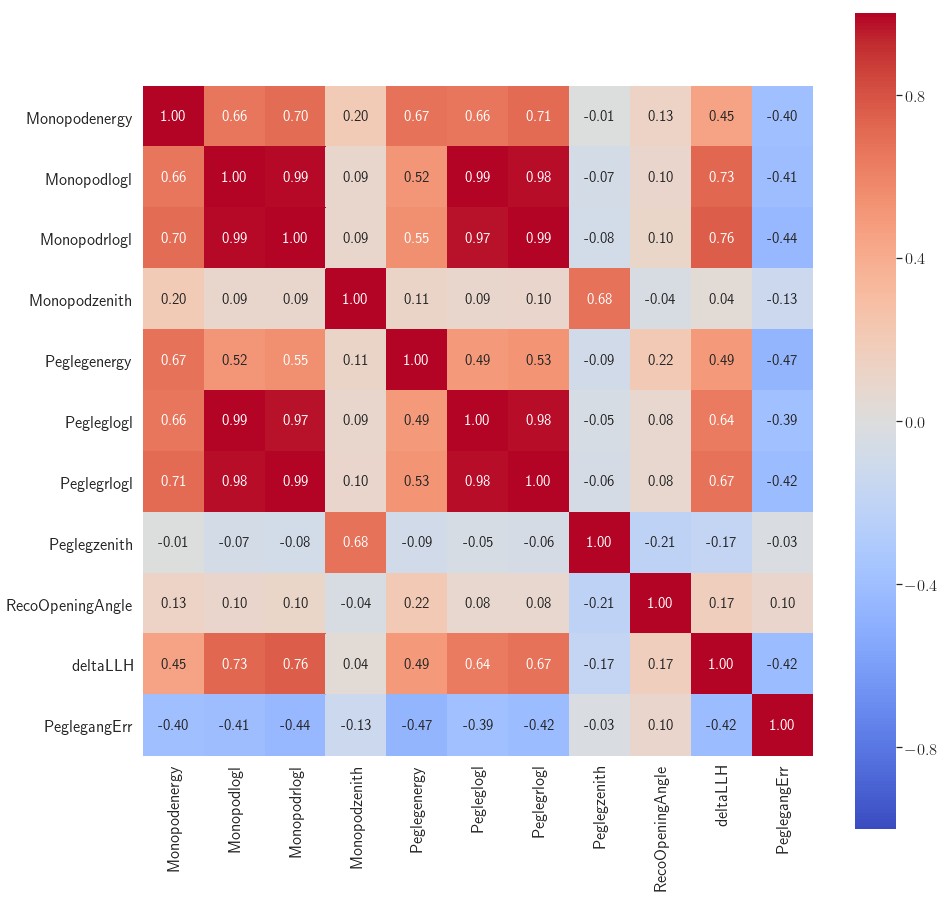

In [41]:
plt.figure(figsize = (15,15))
cm = np.corrcoef(df_train_with_targets.values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
           cbar=True,
           annot=True,
           square=True,
           fmt='.2f',
           annot_kws={'size': 15},
           yticklabels=feature_cols + ["PeglegangErr"],
           xticklabels=feature_cols + ["PeglegangErr"],
           vmin = -1, cmap = 'coolwarm')
plt.show()

## Probably going to ditch azimuth
## We notice there are a lot of variables with relatively strong correlation to Pegleg_angErr
In addition to a random forest, we will try a linear classifier as well

In [42]:
#Start with a single forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV

/home/apizzuto/.local/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/apizzuto/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/apizzuto/.local/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  

In [33]:
feature_cols = list(df.keys())
feature_cols.remove('Monopod_angErr')
feature_cols.remove('Pegleg_angErr')
feature_cols.remove('Monopod_azimuth')
feature_cols.remove('Pegleg_azimuth')
feature_cols.remove('trueEnergy')
feature_cols.remove('weight')
fake_feature_cols  = feature_cols 
fake_feature_cols.remove('Monopod_logl')
fake_feature_cols.remove('Monopod_zenith')
fake_feature_cols.remove('Pegleg_logl')
fake_feature_cols.remove('RecoOpeningAngle')
fake_feature_cols.remove('deltaLLH')

X,y = df[fake_feature_cols].values, df['Pegleg_angErr'].values

X_train, X_test, y_train, y_test =  train_test_split(X, y, 
                                                     test_size=0.5, 
                                                     random_state=1) 

fake_forest = RandomForestRegressor(n_estimators=50, 
                               max_depth = 25,
                               max_features = 3,
                               min_samples_split = 1000,
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=10)

fake_forest.fit(X_train, y_train)
y_train_pred = fake_forest.predict(X_train)
y_test_pred = fake_forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

outfile = '/data/user/apizzuto/Nova/RandomForests/FakeForestForEarlySensitivities.sav'
pickle.dump(fake_forest, open(outfile, 'wb'))

MSE train: 0.120, test: 0.124
R^2 train: 0.481, test: 0.469


In [34]:
fake_feature_cols

['Monopod_energy',
 'Monopod_rlogl',
 'Pegleg_energy',
 'Pegleg_rlogl',
 'Pegleg_zenith']

In [45]:
forest = RandomForestRegressor(n_estimators=30, 
                               max_depth = 40,
                               max_features = 3,
                               min_samples_split = 1000,
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=10)

forest.fit(X_train_std, y_train)
y_train_pred = forest.predict(X_train_std)
y_test_pred = forest.predict(X_test_std)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 0.119, test: 0.121
R^2 train: 0.504, test: 0.494


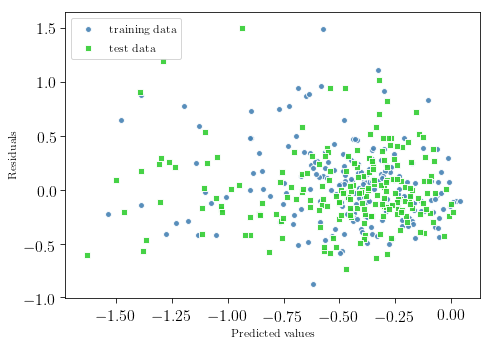

In [16]:
plt.figure(figsize = (7,5))
rand_samp = np.random.choice(int(np.size(df['Pegleg_angErr']) * 0.2), 200)

plt.scatter(y_train_pred[rand_samp],  
            y_train_pred[rand_samp] - y_train[rand_samp], 
            c='steelblue',
            edgecolor='white',
            marker='o', 
            s=35,
            alpha=0.9,
            label='training data')
plt.scatter(y_test_pred[rand_samp],  
            y_test_pred[rand_samp] - y_test[rand_samp], 
            c='limegreen',
            edgecolor='white',
            marker='s', 
            s=35,
            alpha=0.9,
            label='test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc=2)
#plt.yscale('log')
#plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
#plt.xlim([-1, 1])
plt.tight_layout()

# plt.savefig('images/10_14.png', dpi=300)
plt.show()

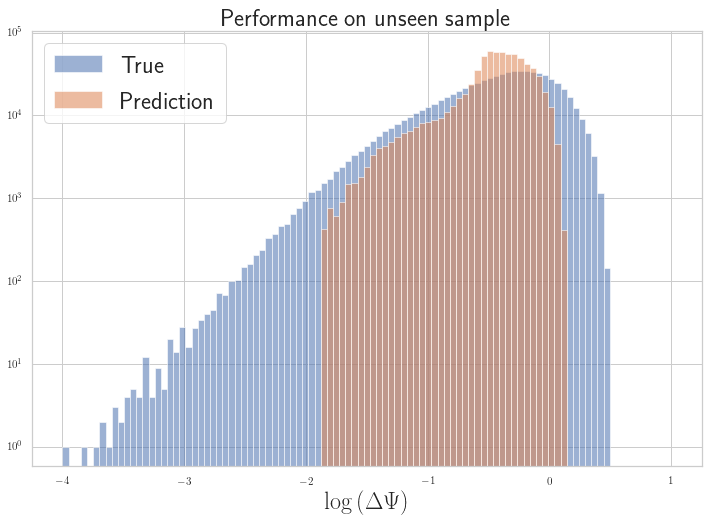

In [52]:
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize = (12,8))
x_vals = np.linspace(-4,1,100)
plt.hist(y_test, bins = x_vals, alpha = 0.55, label = "True")
plt.hist(y_test_pred, bins = x_vals, alpha = 0.55, label = "Prediction")
plt.legend(loc = 2, fontsize = 24)
plt.yscale('log')
plt.xlabel(r'$\log\Big( \Delta\Psi\Big)$', fontsize = 24)
plt.title("Performance on unseen sample", fontsize = 24)
plt.show()

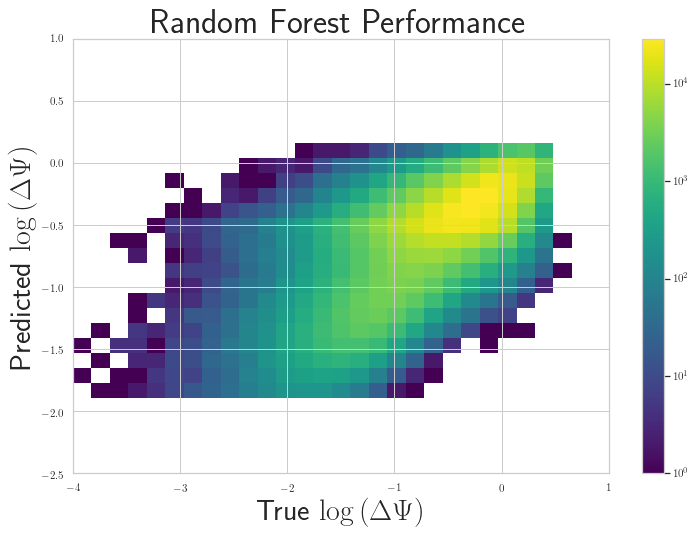

In [99]:
f = plt.figure(figsize=(12,8))
ax = f.add_subplot(111)
#ax2 = f.add_subplot(122)
#fig, ax = plt.subplots()
cax = ax.hist2d(y_test, y_test_pred, 
       bins = [np.linspace(-4.,1.,30), np.linspace(-2.5,1.,30)], 
        cmap = 'viridis', norm=LogNorm())
ax.set_title('Random Forest Performance', fontsize = 34)
plt.xlabel(r'True $\log\Big( \Delta\Psi\Big)$', fontsize = 30)
plt.ylabel(r'Predicted $\log\Big( \Delta\Psi\Big)$', fontsize = 30)
plt.colorbar(cax[3], ax=ax, ticks=[1, 1e1, 1e2, 1e3, 1e4])

# Add colorbar, make sure to specify tick locations to match desired ticklabels
#cbar = fig.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar

plt.show()


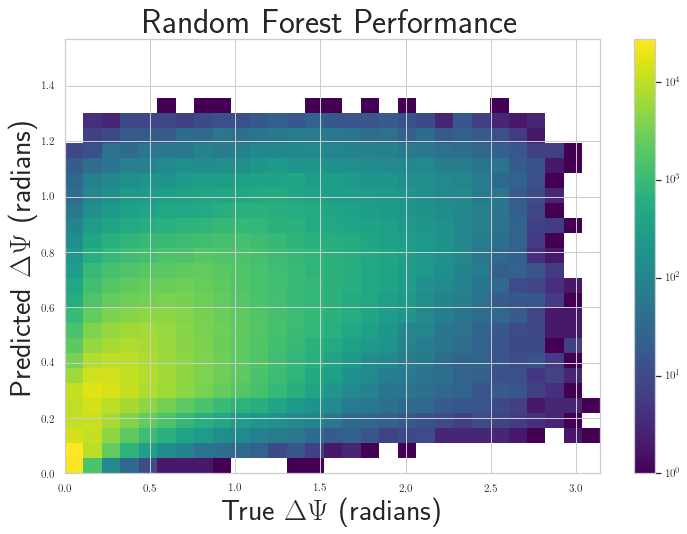

In [98]:
f = plt.figure(figsize=(12,8))
ax = f.add_subplot(111)
#ax2 = f.add_subplot(122)
#fig, ax = plt.subplots()
cax = ax.hist2d(np.power(10,y_test), np.power(10, y_test_pred), 
       bins = [np.linspace(0,np.pi,30), np.linspace(0,np.pi / 2,30)], 
        cmap = 'viridis', norm=LogNorm())
ax.set_title('Random Forest Performance', fontsize = 34)
plt.xlabel(r'True $\Delta\Psi$ (radians)', fontsize = 30)
plt.ylabel(r'Predicted $\Delta\Psi$ (radians)', fontsize = 30)
plt.colorbar(cax[3], ax=ax, ticks=[1, 1e1, 1e2, 1e3, 1e4])

# Add colorbar, make sure to specify tick locations to match desired ticklabels
#cbar = fig.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar

plt.show()


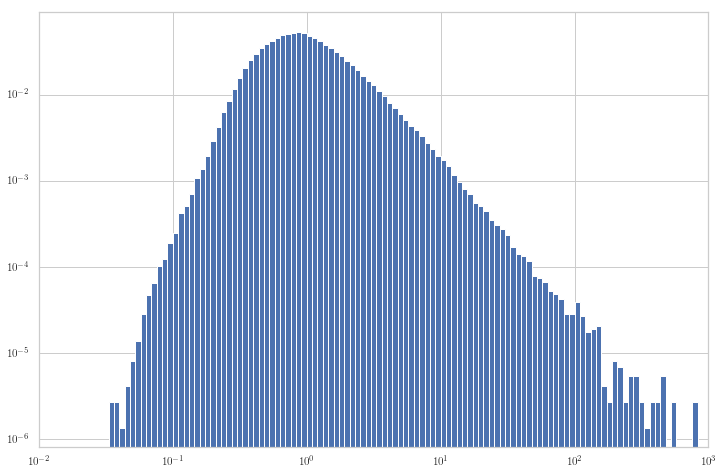

In [101]:
residual_quotient = np.power(10, y_test_pred) / np.power(10, y_test)
f = plt.figure(figsize=(12,8))

h = plt.hist(residual_quotient, weights=np.ones_like(residual_quotient) / len(residual_quotient), bins = np.logspace(-3.,3.,151))
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-2, 1e3)
plt.show()

In [103]:
print np.sum(h[0])
mask = h[1] < 0.5
mask += h[1] > 2.
mask = ~mask

hist = np.append(h[0][0], h[0])
print np.sum(hist[mask]) / np.sum(h[0])

mask = h[1] < 0.2
mask += h[1] > 5.
mask = ~mask

hist = np.append(h[0][0], h[0])
print np.sum(hist[mask]) / np.sum(h[0])

0.9999986440519236
0.6490018183277089
0.95308281728197


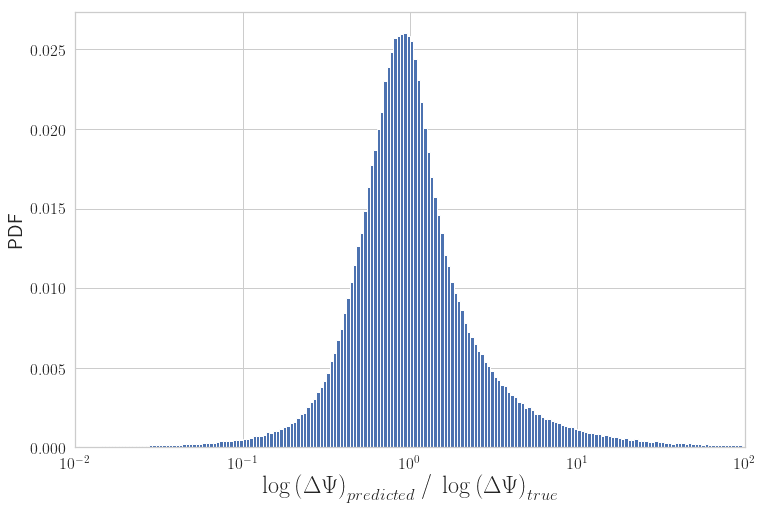

In [95]:
residual_log_quotient =  y_test_pred / y_test
f = plt.figure(figsize=(12,8))

h = plt.hist(residual_log_quotient, weights=np.ones_like(residual_log_quotient) / float(len(residual_log_quotient)), bins = np.logspace(-3.,3.,301))
#plt.yscale('log')
plt.xscale('log')
plt.ylabel("PDF", fontsize = 20)
plt.xlabel("$\log\Big( \Delta\Psi\Big)_{predicted} \; \Bigg/ \; \log\Big( \Delta\Psi\Big)_{true}$", fontsize = 24)
plt.xlim(1e-2, 1e2)
plt.tick_params(labelsize = 16)
plt.show()

In [94]:
np.sum(h[0]) 

0.8508024493825018

In [96]:
mask = h[1] < 0.5
mask += h[1] > 2.
mask = ~mask

hist = np.append(h[0][0], h[0])
np.sum(hist[mask]) / np.sum(h[0])

0.6852245561473227

In [97]:
mask = h[1] < 0.2
mask += h[1] > 5.
mask = ~mask

hist = np.append(h[0][0], h[0])
np.sum(hist[mask]) / np.sum(h[0])

0.9131243425877226

In [76]:
np.sum(hist[~mask])

0.2711134493655757

In [79]:
np.sum(h[0])

0.8510614352415119

In [77]:
np.sum(hist[mask]) + np.sum(hist[~mask])

0.8510627911884239

In [17]:
#Now, a grid search

param_grid = {
'n_estimators': [int(x) for x in np.linspace(10,50,4)],
'max_features': [int(x) for x in np.linspace(1, len(feature_cols), 4)],
'max_depth': [int(x) for x in np.linspace(3,18,6)],
'min_samples_split': [100, 1000, 10000],
'bootstrap': [True, False]
}

param_grid = {
'n_estimators': [2,3],
'max_features': [2,3],
'max_depth': [3,4],
'min_samples_split': [100,1000]
}

forest = RandomForestRegressor()

#weight = df['weight'] * np.power(df['trueEnergy'], -2)

rf_search = GridSearchCV(estimator = forest,
                        param_grid = param_grid,
                        cv = 3,
                        n_jobs = 8,
                        verbose = 3)

rf_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] max_features=2, min_samples_split=100, n_estimators=2, max_depth=3 
[CV] max_features=2, min_samples_split=100, n_estimators=2, max_depth=3 
[CV] max_features=2, min_samples_split=100, n_estimators=2, max_depth=3 
[CV] max_features=2, min_samples_split=100, n_estimators=3, max_depth=3 
[CV] max_features=2, min_samples_split=100, n_estimators=3, max_depth=3 
[CV] max_features=2, min_samples_split=100, n_estimators=3, max_depth=3 
[CV] max_features=2, min_samples_split=1000, n_estimators=2, max_depth=3 
[CV] max_features=2, min_samples_split=1000, n_estimators=2, max_depth=3 
[CV]  max_features=2, min_samples_split=100, n_estimators=2, max_depth=3, score=0.341909 -   1.0s
[CV] max_features=2, min_samples_split=1000, n_estimators=2, max_depth=3 
[CV]  max_features=2, min_samples_split=100, n_estimators=2, max_depth=3, score=0.343328 -   1.2s
[CV] max_features=2, min_samples_split=1000, n_estimators=3, max_depth=3 
[CV]  max

[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    4.6s


[CV]  max_features=3, min_samples_split=100, n_estimators=3, max_depth=3, score=0.339334 -   2.2s
[CV] max_features=2, min_samples_split=100, n_estimators=2, max_depth=4 
[CV]  max_features=3, min_samples_split=1000, n_estimators=2, max_depth=3, score=0.358437 -   1.6s
[CV] max_features=2, min_samples_split=100, n_estimators=2, max_depth=4 
[CV]  max_features=3, min_samples_split=1000, n_estimators=2, max_depth=3, score=0.361458 -   1.5s
[CV] max_features=2, min_samples_split=100, n_estimators=2, max_depth=4 
[CV]  max_features=3, min_samples_split=1000, n_estimators=2, max_depth=3, score=0.335894 -   1.5s
[CV] max_features=2, min_samples_split=100, n_estimators=3, max_depth=4 
[CV]  max_features=3, min_samples_split=100, n_estimators=3, max_depth=3, score=0.361923 -   2.4s
[CV] max_features=2, min_samples_split=100, n_estimators=3, max_depth=4 
[CV]  max_features=3, min_samples_split=1000, n_estimators=3, max_depth=3, score=0.361069 -   2.2s
[CV] max_features=2, min_samples_split=100,

[Parallel(n_jobs=8)]: Done  48 out of  48 | elapsed:   12.8s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=8,
       param_grid={'n_estimators': [2, 3], 'max_features': [2, 3], 'min_samples_split': [100, 1000], 'max_depth': [3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

with no weighting, it looks like we can get to around an R^2 of 0.5

In [18]:
rf_search.grid_scores_

[mean: 0.34159, std: 0.00156, params: {'max_features': 2, 'min_samples_split': 100, 'n_estimators': 2, 'max_depth': 3},
 mean: 0.34492, std: 0.00089, params: {'max_features': 2, 'min_samples_split': 100, 'n_estimators': 3, 'max_depth': 3},
 mean: 0.32707, std: 0.02199, params: {'max_features': 2, 'min_samples_split': 1000, 'n_estimators': 2, 'max_depth': 3},
 mean: 0.32742, std: 0.00366, params: {'max_features': 2, 'min_samples_split': 1000, 'n_estimators': 3, 'max_depth': 3},
 mean: 0.35292, std: 0.01160, params: {'max_features': 3, 'min_samples_split': 100, 'n_estimators': 2, 'max_depth': 3},
 mean: 0.34633, std: 0.01105, params: {'max_features': 3, 'min_samples_split': 100, 'n_estimators': 3, 'max_depth': 3},
 mean: 0.35193, std: 0.01141, params: {'max_features': 3, 'min_samples_split': 1000, 'n_estimators': 2, 'max_depth': 3},
 mean: 0.35903, std: 0.00154, params: {'max_features': 3, 'min_samples_split': 1000, 'n_estimators': 3, 'max_depth': 3},
 mean: 0.36120, std: 0.00914, params

In [19]:
print (rf_search.best_params_)

{'max_features': 3, 'min_samples_split': 1000, 'n_estimators': 3, 'max_depth': 4}


In [22]:
dumpName = "/home/apizzuto/Nova/RandomForests/testForest.sav"
pickle.dump(rf_search, open(dumpName, 'wb'))

In [28]:
myForst = pickle.load(open('/home/apizzuto/Nova/RandomForests/testGridSearchResults_azimuth_True_logSeparation_True_standardize_True', 'rb'))
myForst.best_params_

{'max_depth': 4,
 'max_features': 3,
 'min_samples_split': 1000,
 'n_estimators': 3}

In [60]:
bestTree = rf_search.best_estimator_
bestTree.fit(X_train, y_train)

y_train_pred = bestTree.predict(X_train)
y_test_pred = bestTree.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 0.120, test: 0.120
R^2 train: 0.500, test: 0.494


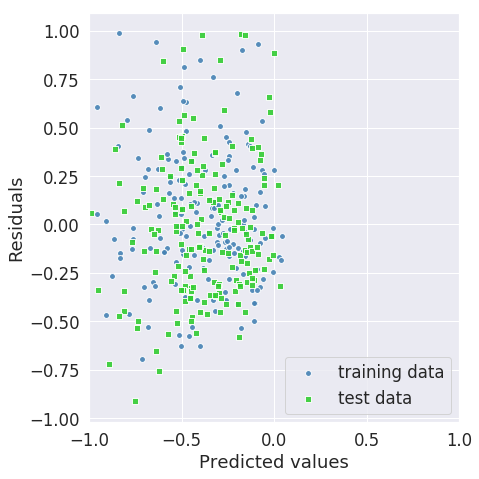

In [61]:
plt.figure(figsize = (7,7))
rand_samp = np.random.choice(int(np.size(df['Pegleg_angErr']) * 0.2), 200)

plt.scatter(y_train_pred[rand_samp],  
            y_train_pred[rand_samp] - y_train[rand_samp], 
            c='steelblue',
            edgecolor='white',
            marker='o', 
            s=35,
            alpha=0.9,
            label='training data')
plt.scatter(y_test_pred[rand_samp],  
            y_test_pred[rand_samp] - y_test[rand_samp], 
            c='limegreen',
            edgecolor='white',
            marker='s', 
            s=35,
            alpha=0.9,
            label='test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc=4)
#plt.yscale('log')
#plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-1, 1])
plt.tight_layout()

# plt.savefig('images/10_14.png', dpi=300)
plt.show()

## Things to try

* Grid search with regular parameters and normal weighting
* Grid seatch with regular parameters and weighting with separation
* Grid search with transformed parameters and normal weighting
* Grid search with transformed parameters and weighting with separation